# Market Basket Analysis

## What is Market basket analysis?
A Data mining technique used to identify patterns in customer purchasing behaviour by analysing which items were frquently brought together.

## About the Dataset: 
Were having six csv files named,
1.) Aisles
2.) Departments
3.) Order of products (prior)
4.) Order of products (train)
5.) Orders
6.) Products

Now, lets see what each of them mean and the questions we try to raise from them. 

In [43]:
%matplotlib inline
#Use this cell for imports and if there's a need to install, add a cell below
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline

In [8]:
#This is supposed to be like an aisle in a supermarket 
aisle = pd.read_csv("/kaggle/input/instacart-customer-data/aisles.csv/aisles.csv")
aisle.head()
#aisle["aisle"].value_counts() #total 134 unique values. All are unique

#Now, a question would be which aisle is ordered the most and which is used the least
#Second, what product percentage here would be used most from the aisle

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [9]:
departments = pd.read_csv("/kaggle/input/instacart-customer-data/departments.csv/departments.csv")
departments.head()
#Total of 20 departments

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [10]:
orders_prior = pd.read_csv("/kaggle/input/instacart-customer-data/order_products__prior.csv/order_products__prior.csv") 
print(orders_prior.head())

   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


In [11]:
orders_train = pd.read_csv("/kaggle/input/instacart-customer-data/order_products__train.csv/order_products__train.csv")
print(orders_train.head())
orders_train.info() #About 1.3 million rows
#Here, we see if the order was reordered or how many times it was added to cart

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [12]:
orders = pd.read_csv("/kaggle/input/instacart-customer-data/orders.csv/orders.csv")
print(orders.head())
orders.describe()
#3.4 million rows
#Order_dow is order from day of the week
print(orders['eval_set'].value_counts())
"""The above line is to see how the data is split between train and test
and validades that we have ~210,000 customers. The next line would be to validate that we have 
a range for minimum (4) and maximum(100) orders per customer."""

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
eval_set
prior    3214874
train     131209
test       75000
Name: count, dtype: int64


'The above line is to see how the data is split between train and test\nand validades that we have ~210,000 customers. The next line would be to validate that we have \na range for minimum (4) and maximum(100) orders per customer.'

In [13]:
products = pd.read_csv("/kaggle/input/instacart-customer-data/products.csv/products.csv")
products.head()
products.info()
#49k products

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Exploratory Data Analysis

### Validation

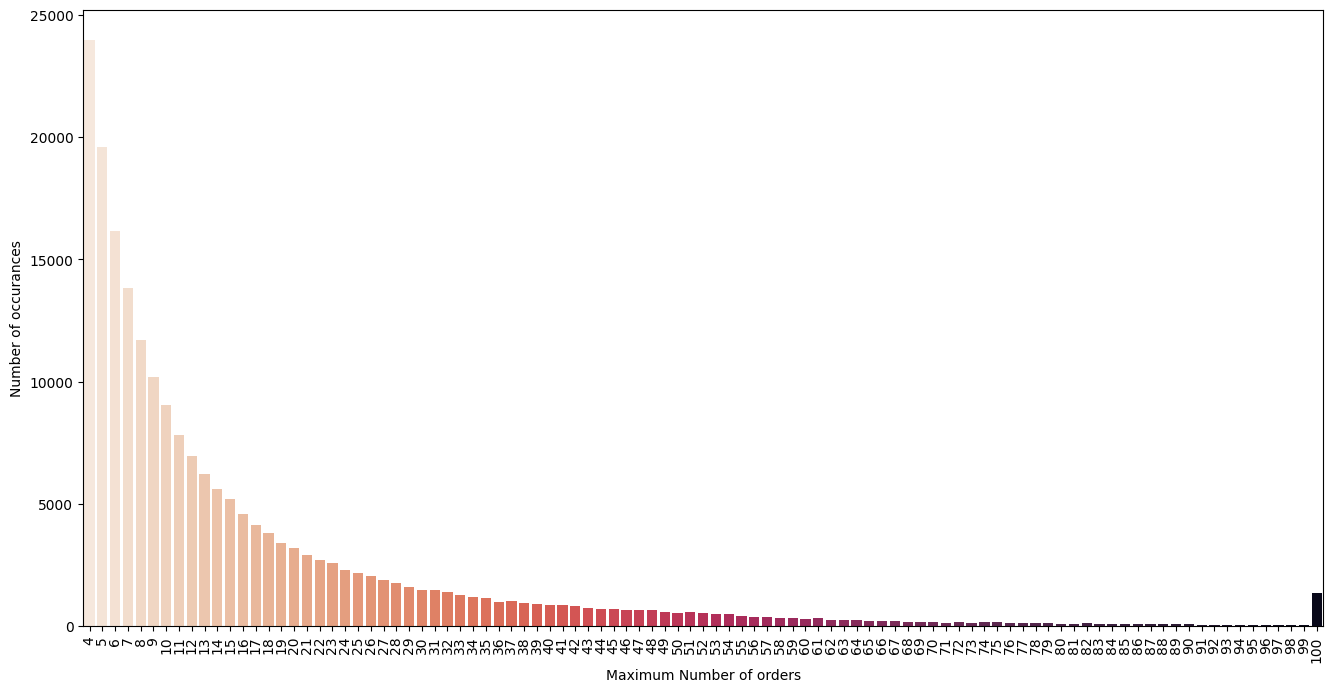

In [14]:
"""Now, lets validate that we have orders 4 to 100 per each customer. 
This would also help us with a rough idea about our customer retention and how many customers 
are reordering and how many times."""

count_customers = orders.groupby("user_id")["order_number"].aggregate(np.max).reset_index()
count_customers = count_customers.order_number.value_counts()
#Now, we'll see how what is the maximum number of times a customer has re-ordered. Now, let's plot it

plt.figure(figsize=(16,8))
sns.barplot(x=count_customers.index, y=count_customers.values, alpha=1.0, palette='rocket_r')
plt.ylabel("Number of occurances")
plt.xlabel("Maximum Number of orders")
plt.xticks(rotation = "vertical")
plt.show()

#So this validates for us that we have numbers of orders between 4 and 100 with number 4 the most times

## Ordering habits.
Many possibilities
* Number of orders by days.
* Number of orders by hour (also on each day).
* Which products are the bestsellers on what aisle and departments?  
* What aisles have been ordered the most from?
* What departments are having the most number of (bestselling) aisle?
* Are they in the cart and not being reordered?
* What products aren't reordered?
* What products are reordered the most?
* What is the ratio of reorders to other factors?

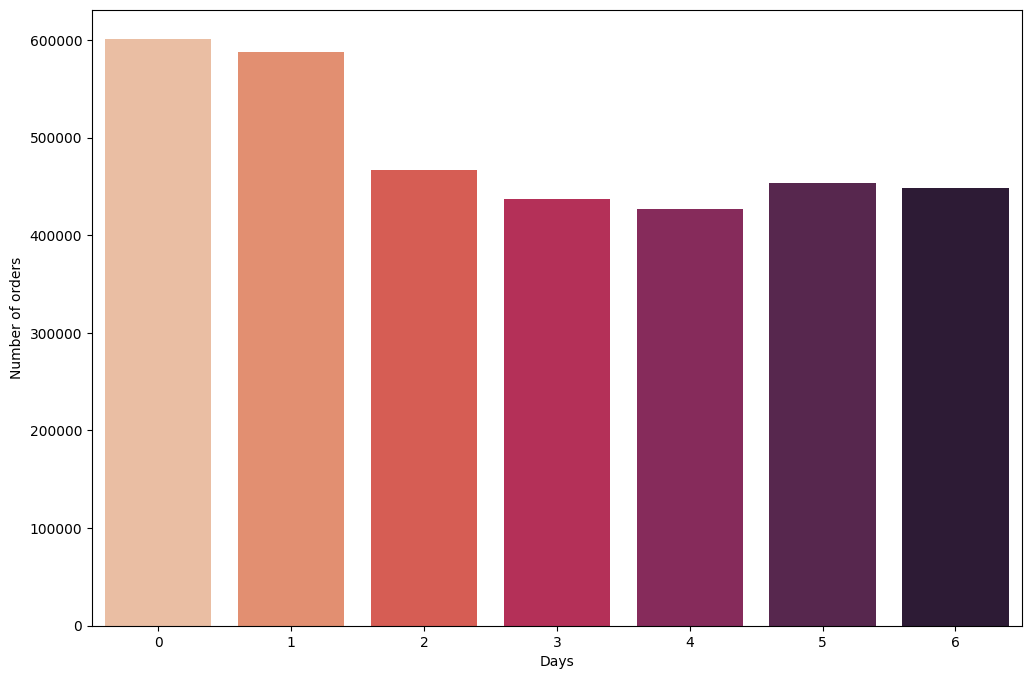

In [15]:
#1 Number of orders on a particular day where day 0 = Sunday
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data = orders, palette = "rocket_r")
plt.ylabel("Number of orders")
plt.xlabel("Days")
plt.show()

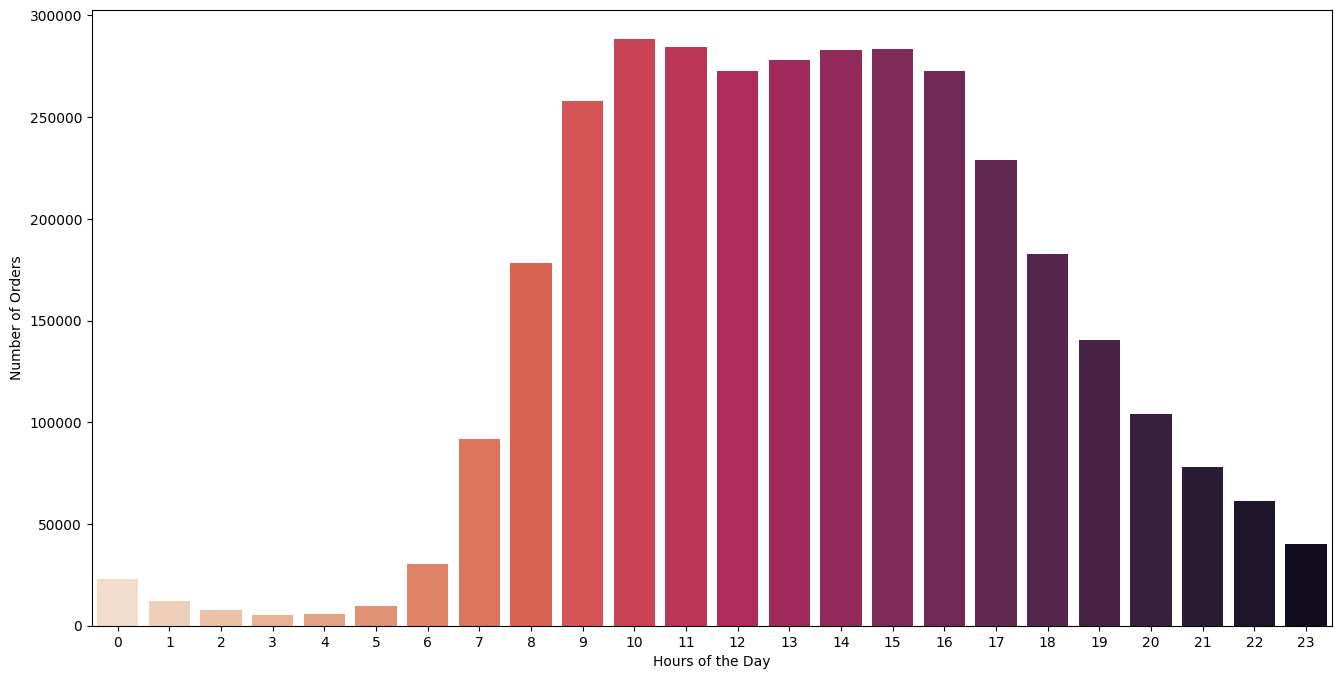

In [16]:
#So, here we can see that the most of orders are placed between 10 AM - 3PM and goes downhill from there.
plt.figure(figsize=(16,8))
sns.countplot(x = 'order_hour_of_day', data = orders, palette = "rocket_r")
plt.ylabel("Number of Orders")
plt.xlabel("Hours of the Day")
plt.show()

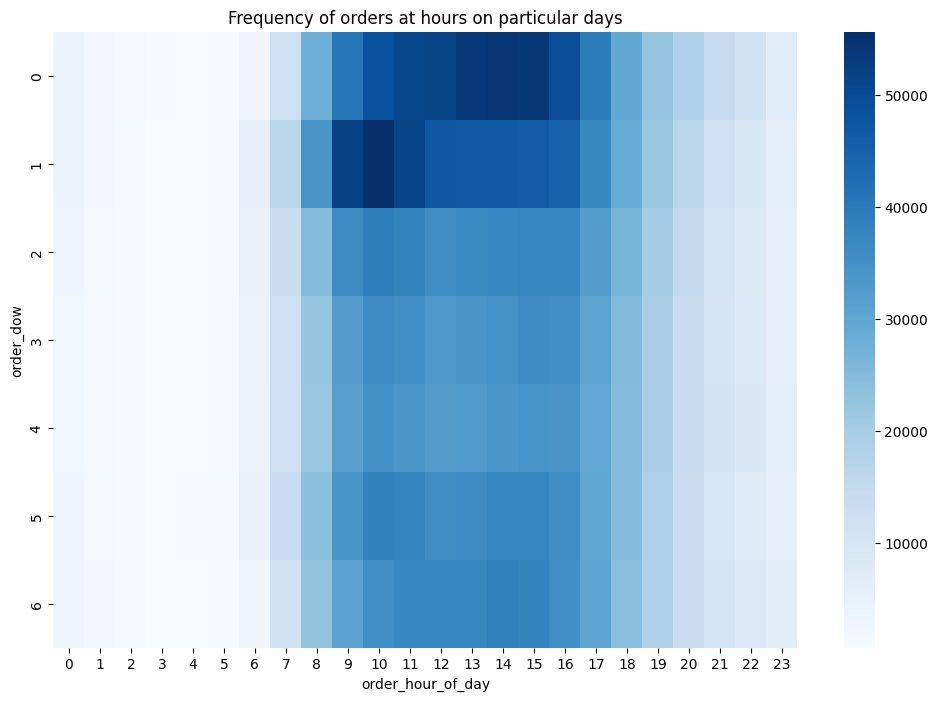

'So, the analysis says that on Saturday between 1 PM to 4 PM, \nthe orders cross 50000 mark and same behavior is noticed on a Sunday too, between 10-12 AM'

In [17]:
#Now we'll see which hour has the most orders on which day
hours_by_days = orders.groupby(['order_dow','order_hour_of_day'])['order_number'].aggregate("count").reset_index()
hours_by_days = hours_by_days.pivot(index='order_dow', columns='order_hour_of_day', values='order_number')

plt.figure(figsize=(12,8))
sns.heatmap(hours_by_days,cmap="Blues")
plt.title("Frequency of orders at hours on particular days")
plt.show()

"""So, the analysis says that on Saturday between 1 PM to 4 PM, 
the orders cross 50000 mark and same behavior is noticed on a Sunday too, between 10-12 AM"""  

In [18]:
hours_by_days

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
order_dow,,,,,,,,,,,,,,,,,,,,,
0,3936,2398,1409,963,813,1168,3329,12410,28108,40798,...,54552,53954,49463,39753,29572,22654,18277,14423,11246,6887
1,3674,1830,1105,748,809,1607,5370,16571,34116,51908,...,46764,46403,44761,36792,28977,22145,16281,11943,8992,5620
2,3059,1572,943,719,744,1399,4758,13245,24635,36314,...,37173,37469,37541,32151,26470,20084,15039,10653,8146,5358
3,2952,1495,953,654,719,1355,4562,12396,22553,32312,...,34773,35990,35273,30368,25001,19249,13795,10278,8242,5181
4,2642,1512,899,686,730,1330,4401,12493,21814,31409,...,33625,34222,34093,29378,24425,19350,14186,10796,8812,5645
5,3189,1672,1016,841,910,1574,4866,13434,24015,34232,...,37407,37508,35860,29955,24310,18741,13322,9515,7498,5265
6,3306,1919,1214,863,802,1136,3243,11319,22960,30839,...,38748,38093,35562,30398,24157,18346,13392,10501,8532,6087


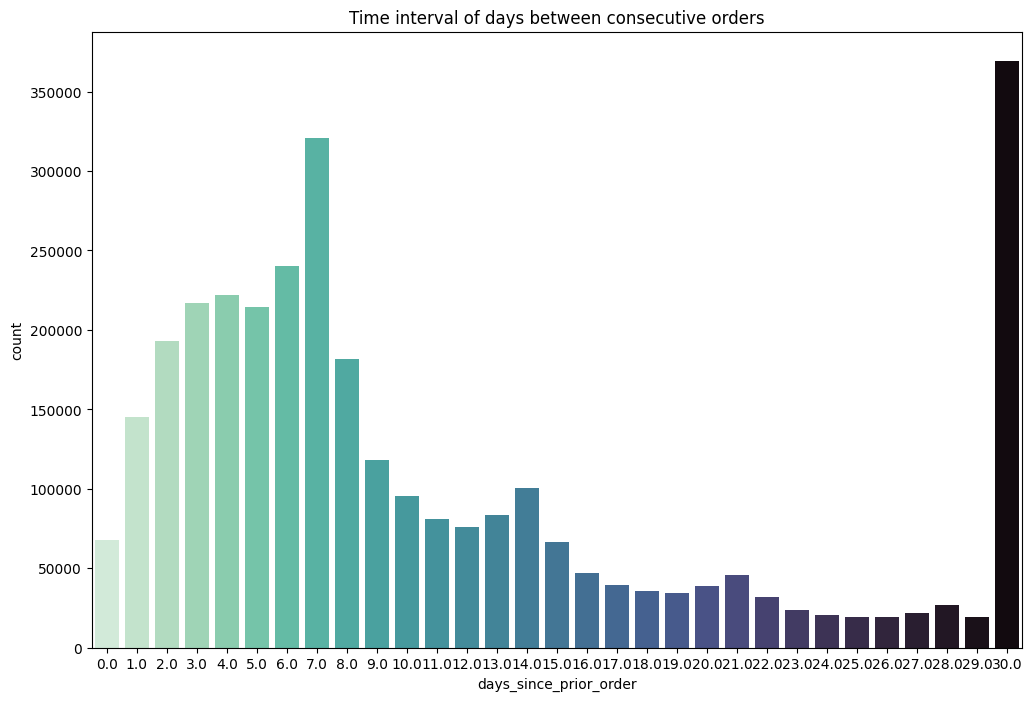

'We can see that the peaks are either created at the 7th day or at the 30th day.\nSo, either a weekend or a monthend.\nAdditionally, we can also see the peaks on the 7th, 14th and the 21st day. \n'

In [19]:
#Now let's check the time intervals between the placed orders
plt.figure(figsize=(12,8))
sns.countplot(x='days_since_prior_order', data = orders, palette = 'mako_r')
plt.title("Time interval of days between consecutive orders")
plt.show()

"""We can see that the peaks are either created at the 7th day or at the 30th day.
So, either a weekend or a monthend.
Additionally, we can also see the peaks on the 7th, 14th and the 21st day. 
"""

In [20]:
# #how many products were reordered
# orders_prior[orders_prior["reordered"] == 1]["product_id"].count()
# #1.9 reorders which makes it
#Percentage of how many products were reordered in the prior data
percent_reorders = round(orders_prior['reordered'].sum()/len(orders_prior['reordered']),4)*100
print(f"Reorders in prior data: {percent_reorders}%")

Reorders in prior data: 58.97%


In [21]:
#Percentage of how many products were reordered in the train dataset
percent_reorders = round(orders_train['reordered'].sum()/len(orders_train['reordered']),4)*100
print(f"Reorders in train data: {percent_reorders}%")

Reorders in train data: 59.86%


## Product based Analysis

In [22]:
orders_prior_merged = pd.merge(orders, orders_prior, on='order_id', how = "left")
orders_prior_merged.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196.0,1.0,0.0
1,2539329,1,prior,1,2,8,NaN,14084.0,2.0,0.0
2,2539329,1,prior,1,2,8,NaN,12427.0,3.0,0.0
3,2539329,1,prior,1,2,8,NaN,26088.0,4.0,0.0
4,2539329,1,prior,1,2,8,NaN,26405.0,5.0,0.0
5,2398795,1,prior,2,3,7,15.0,196.0,1.0,1.0
6,2398795,1,prior,2,3,7,15.0,10258.0,2.0,0.0
7,2398795,1,prior,2,3,7,15.0,12427.0,3.0,1.0
8,2398795,1,prior,2,3,7,15.0,13176.0,4.0,0.0
9,2398795,1,prior,2,3,7,15.0,26088.0,5.0,1.0


In [31]:
orders_products = pd.merge(orders_prior_merged,products, on='product_id',how='left')
orders_products = pd.merge(orders_products, departments, on = 'department_id', how='left')
orders_products = pd.merge(orders_products, aisle, on='aisle_id', how='left')

#orders_products.head()
orders_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32640698 entries, 0 to 32640697
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
 7   product_id              float64
 8   add_to_cart_order       float64
 9   reordered               float64
 10  product_name            object 
 11  aisle_id                float64
 12  department_id           float64
 13  department              object 
 14  aisle                   object 
dtypes: float64(6), int64(5), object(4)
memory usage: 3.6+ GB


In [24]:
#Lets see top product for each day
product_days = orders_products.groupby(['order_dow', 'product_name'])['order_id'].count().reset_index(name='product_count')
product_days = product_days.sort_values(['order_dow','product_count'],ascending=[True, False])

top_product_day = product_days.groupby('order_dow')['product_count'].idxmax()
max_scores = product_days.loc[top_product_day]

# .plt.figure(figsize = (12,8))
# sns.
max_scores

#How insightful. Bananas are favorite.
#Next step is to see top products sold by the hour of the day

,order_dow,product_name,product_count
3381,0,Banana,96769
49485,1,Banana,87787
95254,2,Banana,59881
140363,3,Banana,53327
185312,4,Banana,52497
230208,5,Banana,58990
275665,6,Banana,63314


In [25]:
pd.options.display.max_rows = 4000

#Now, lets see what are the best selling products on each hour of the week
product_hours = orders_products.groupby(['order_dow','order_hour_of_day','product_name'])['order_id'].count().reset_index(name='product_count')
product_hours = product_hours.sort_values(['order_dow','order_hour_of_day'],ascending=[True,True])

idx = product_hours.groupby(['order_dow','order_hour_of_day'])['product_count'].idxmax()

top_product_hours = product_hours.loc[idx, ['order_dow', 'order_hour_of_day', 'product_name', 'product_count']]
top_product_hours = top_product_hours.reset_index(drop=True)
top_product_hours

#Great, its all bananas. They're ordering bananas even in the morning/night. 

,order_dow,order_hour_of_day,product_name,product_count
0,0,0,Banana,560
1,0,1,Banana,321
2,0,2,Banana,168
3,0,3,Banana,106
4,0,4,Banana,98
5,0,5,Banana,163
6,0,6,Banana,603
7,0,7,Banana,2214
8,0,8,Banana,4937
9,0,9,Banana,6916


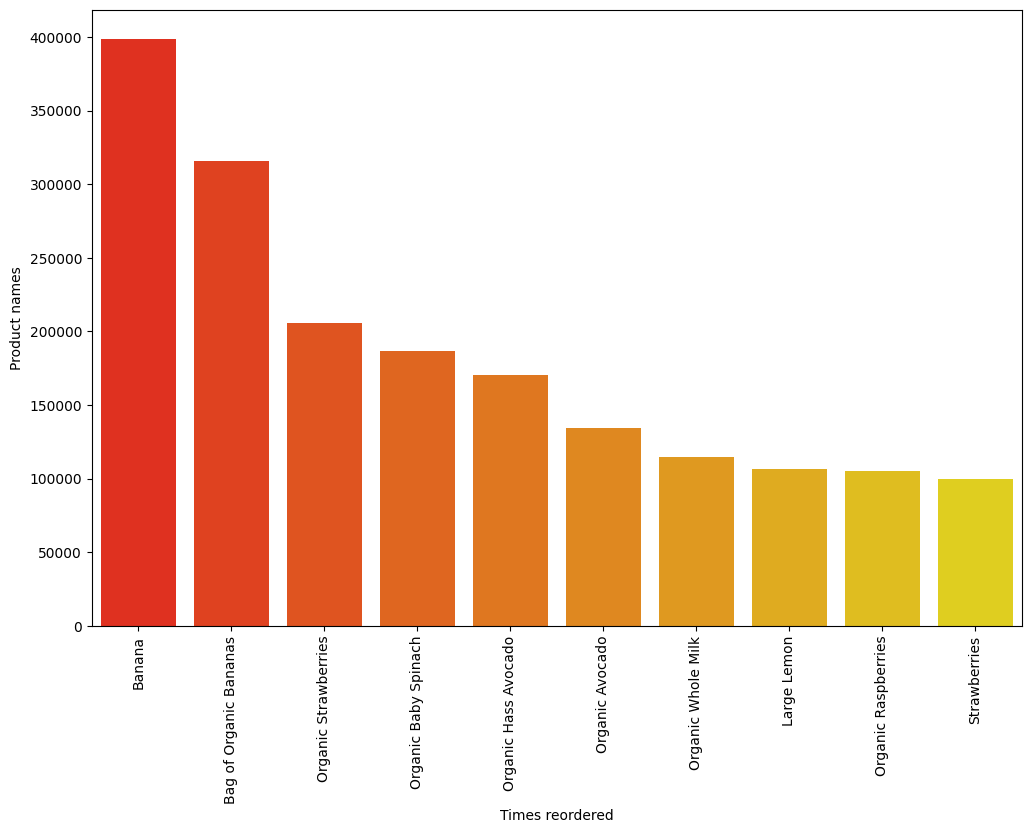

In [26]:
#Now, let's see what are the most reordered products
reordered_products = orders_products.groupby('product_name')['reordered'].sum().reset_index(name='times_reordered')
reordered_products = reordered_products.sort_values('times_reordered',ascending=False)
reordered_products = reordered_products.nlargest(10,'times_reordered')

#Almost everything reordered is organic
plt.figure(figsize=(12,8))
sns.barplot(x= 'product_name', y= 'times_reordered', data= reordered_products, palette= 'autumn')
plt.ylabel('Product names')
plt.xlabel('Times reordered')
plt.xticks(rotation=90)
plt.show()

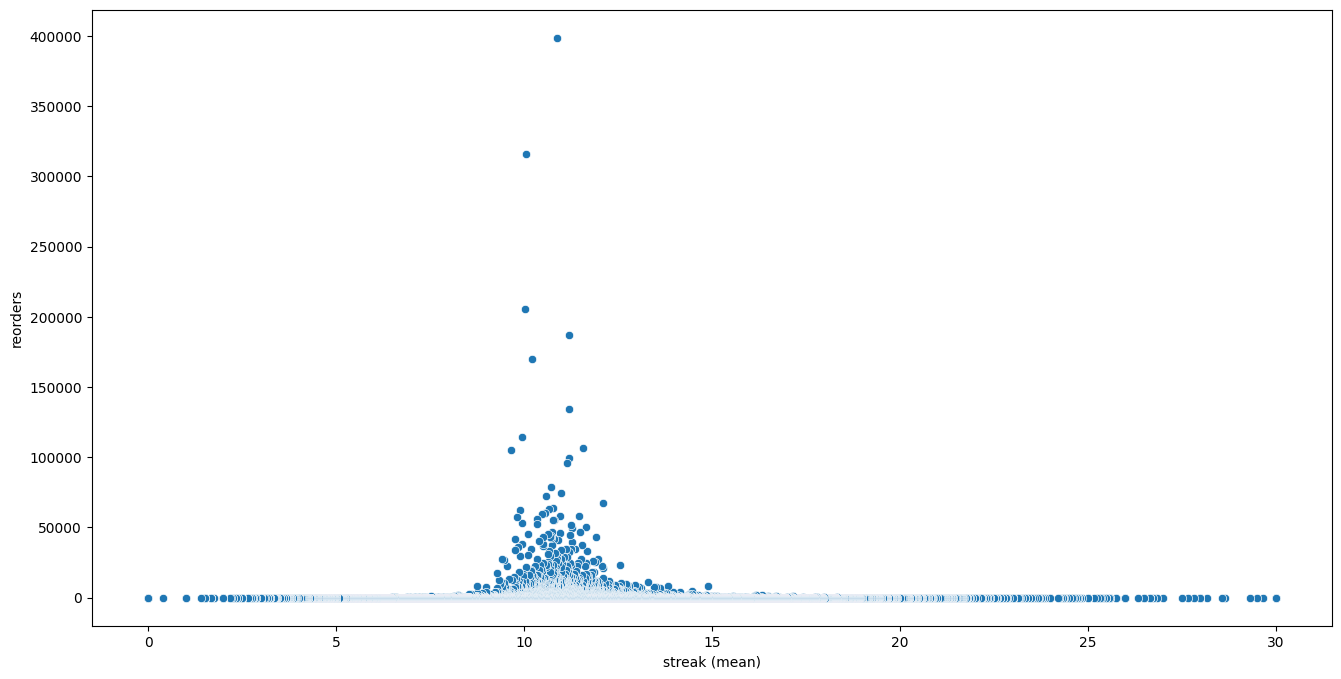

In [41]:
#Now, let's see what is the streak or let's say after how many days each prouct was ordered

streak = orders_products.groupby('product_name').agg(
    streak=('days_since_prior_order', 'mean'),  # Mean streak
    reorders=('reordered', 'sum') #Total reorders
)
streak = streak.sort_values('streak', ascending=False)
#streak = streak.nlargest(10,'streak')

streak

#lets do a scatterplot for this
plt.figure(figsize=(16,8))
sns.scatterplot(x='streak', y='reorders', data= streak, palette= 'autumn')
plt.xlabel('streak (mean)')
plt.ylabel('reorders')
plt.show()

"""So, here we see that the products which have a mean of 'streak' 
between ~8-15 have increasing number of reorders.
Whereas, products having mean streak at far left and right of the 
distribution aren't really reordered."""

In [ ]:
#Now, let's plot a treemap for aisles and departments wrt products with plotly

fig = px.treemap(orders_products['department'],orders_products['aisle'])
fig.show()